Matplotlib is building the font cache; this may take a moment.


=== My First Pairs Trading Model ===
Python version: 3.12.7 (main, May 15 2025, 18:47:24) [Clang 19.0.0git (https:/github.com/llvm/llvm-project 0a8cd1ed1f4f35905df318015b

--- STEP 1: Creating Stock Price Data ---
Creating 1000 days of data...
✅ Data created.

--- STEP 2: Finding the Hedge Ratio ---
Hedge Ratio (beta): -0.2390
... Generating Regression Scatter Plot ...


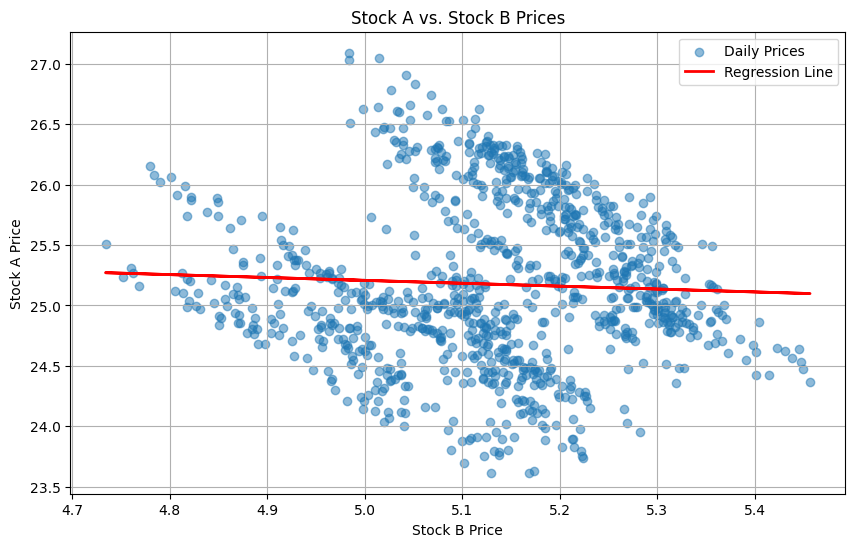


--- STEP 3: Calculating the Spread ---
✅ Spread calculated.
The mean of the spread is: 0.0000 (should be close to 0)

--- STEP 4: Generating Trading Signals ---
✅ Z-Scores calculated.
... Generating Z-Score Plot ...


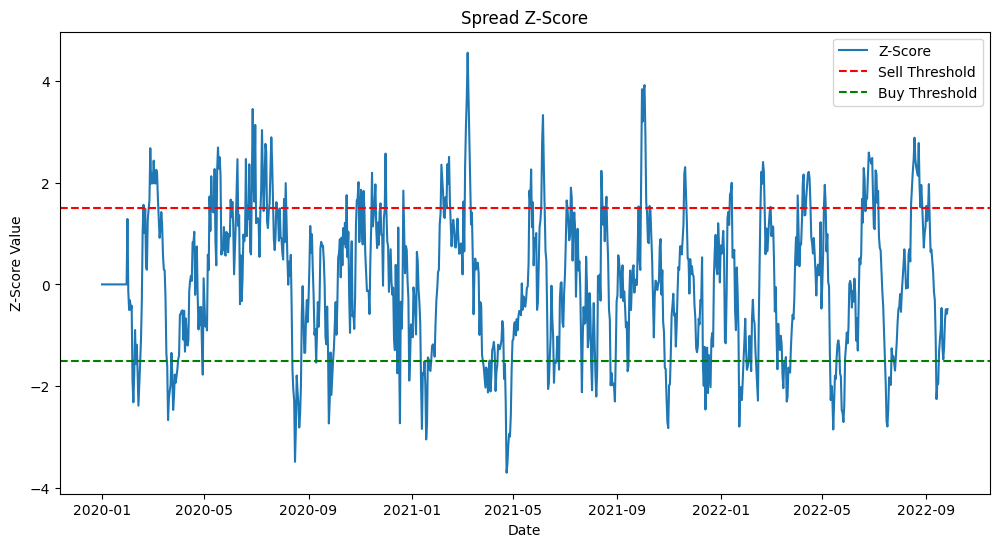


--- STEP 5: Backtesting the Strategy ---
✅ Backtest Finished.

--- Backtest Results ---
Total Trades: 35
Total Net P&L: 4.35
Win Rate: 74.29%
Sharpe Ratio: 0.37
... Generating Equity Curve Plot ...


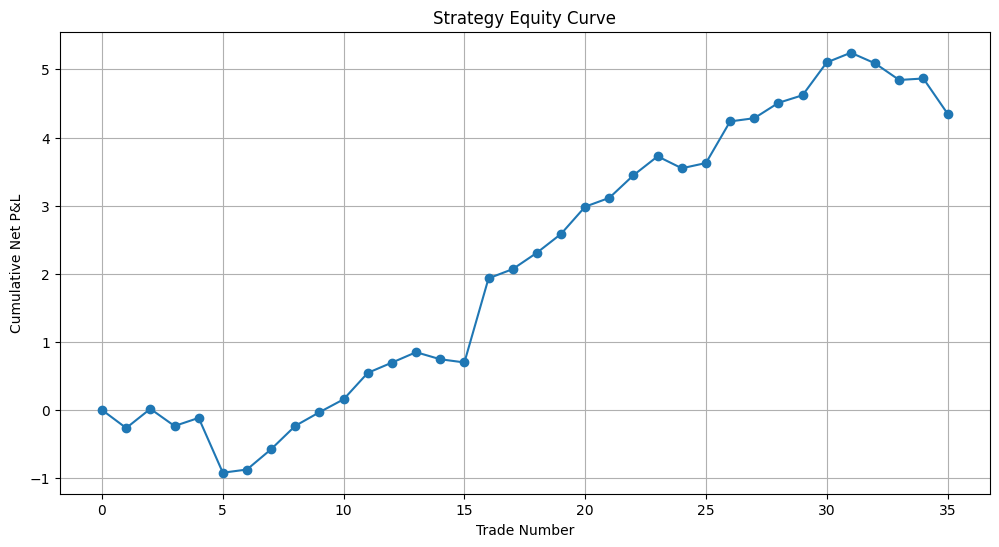

In [1]:
# My First Pairs Trading Model

# --- Imports and Setup ---
import sys
import numpy as np
import matplotlib.pyplot as plt
import math
import random
from datetime import datetime, timedelta

print("=== My First Pairs Trading Model ===")
print("Python version:", sys.version)

# ================================================
# STEP 1: Make up some stock data to test with
# ================================================
print("\n--- STEP 1: Creating Stock Price Data ---")

# Use a seed so the random numbers are the same every time we run it
random.seed(42)
np.random.seed(42)

# How many days of data to make
number_of_days = 1000
print(f"Creating {number_of_days} days of data...")

# Make some dates
start_date = datetime(2020, 1, 1)
# this is a list to hold the dates
dates = [start_date + timedelta(days=i) for i in range(number_of_days)]

# We need to create two stocks that are linked together
# 1. A common factor that affects both (like the whole market moving)
# 2. Random noise for each stock
# 3. A special "spread" that pulls them back together

# 1. The common factor
common_factor = [0]
for i in range(1, number_of_days):
    change = random.gauss(0, 0.01)
    common_factor.append(common_factor[-1] + change)

# 2. Individual stock noise
stock_A_noise = [random.gauss(0, 0.005) for _ in range(number_of_days)]
stock_B_noise = [random.gauss(0, 0.005) for _ in range(number_of_days)]

# 3. The mean-reverting spread part
spread_component = [0]
for i in range(1, number_of_days):
    # This pulls the spread back to zero
    mean_reversion = -0.05 * spread_component[-1]
    noise = random.gauss(0, 0.3)
    spread_component.append(spread_component[-1] + mean_reversion + noise)

# Now, build the final prices
stock_A_base_price = 25.0
stock_B_base_price = 5.0
# These are lists to hold the final prices
stock_A_prices = []
stock_B_prices = []

# Loop through all the days to build the prices
for i in range(number_of_days):
    price_A = (stock_A_base_price + common_factor[i] * 3.0 + sum(stock_A_noise[:i+1]) + spread_component[i] * 0.5)
    price_B = (stock_B_base_price + common_factor[i] * 0.6 + sum(stock_B_noise[:i+1]) * 0.8 - spread_component[i] * 0.1)
    # make sure prices dont go below zero
    stock_A_prices.append(max(price_A, 1.0))
    stock_B_prices.append(max(price_B, 0.5))

print("✅ Data created.")

# ================================================
# STEP 2: Find the relationship (Regression)
# ================================================
print("\n--- STEP 2: Finding the Hedge Ratio ---")

# We need a function to do linear regression
def my_linear_regression(x, y):
    n = len(x)
    x_mean = sum(x) / n
    y_mean = sum(y) / n
    # beta formula
    numerator = sum((x[i] - x_mean) * (y[i] - y_mean) for i in range(n))
    denominator = sum((x[i] - x_mean)**2 for i in range(n))
    beta = numerator / denominator
    # alpha formula
    alpha = y_mean - beta * x_mean
    return beta, alpha

# Run the regression with our data
# Stock A is y, Stock B is x
hedge_ratio, intercept = my_linear_regression(stock_B_prices, stock_A_prices)
print(f"Hedge Ratio (beta): {hedge_ratio:.4f}")

# Let's plot this to see if it makes sense
print("... Generating Regression Scatter Plot ...")
predicted_A = [intercept + hedge_ratio * b for b in stock_B_prices]
plt.figure(figsize=(10, 6))
plt.scatter(stock_B_prices, stock_A_prices, alpha=0.5, label='Daily Prices')
plt.plot(stock_B_prices, predicted_A, color='red', linewidth=2, label='Regression Line')
plt.title('Stock A vs. Stock B Prices')
plt.xlabel('Stock B Price')
plt.ylabel('Stock A Price')
plt.legend()
plt.grid(True)
plt.savefig('regression_plot.png')
plt.show()


# ================================================
# STEP 3: Calculate the Spread
# ================================================
print("\n--- STEP 3: Calculating the Spread ---")

# The spread is the error from the regression
spread = [stock_A_prices[i] - (intercept + hedge_ratio * stock_B_prices[i]) for i in range(number_of_days)]
print("✅ Spread calculated.")
# Let's check if the spread looks like it reverts to a mean
spread_mean = np.mean(spread)
print(f"The mean of the spread is: {spread_mean:.4f} (should be close to 0)")


# ================================================
# STEP 4: Generate Trading Signals with Z-Scores
# ================================================
print("\n--- STEP 4: Generating Trading Signals ---")

# We need to calculate z-scores for the spread
# z-score = (value - mean) / std_dev
z_scores = []
rolling_window = 30 # use a 30 day window

# loop through the spread data
for i in range(number_of_days):
    if i < rolling_window:
        # Not enough data yet, so just append 0
        z_scores.append(0)
    else:
        # Get the last 30 days of data
        recent_spread_data = spread[i-rolling_window:i]
        
        # Calculate mean and std dev for the window
        window_mean = np.mean(recent_spread_data)
        window_std = np.std(recent_spread_data)
        
        current_spread_value = spread[i]
        
        # Calculate the z-score
        if window_std > 0:
            z_score = (current_spread_value - window_mean) / window_std
        else:
            z_score = 0
        
        # Add the z-score to our list
        z_scores.append(z_score)

print("✅ Z-Scores calculated.")

# Let's plot the z-scores to see them
print("... Generating Z-Score Plot ...")
plt.figure(figsize=(12, 6))
plt.plot(dates, z_scores, label='Z-Score')
plt.axhline(1.5, color='red', linestyle='--', label='Sell Threshold')
plt.axhline(-1.5, color='green', linestyle='--', label='Buy Threshold')
plt.title('Spread Z-Score')
plt.xlabel('Date')
plt.ylabel('Z-Score Value')
plt.legend()
plt.savefig('z_score_plot.png')
plt.show()


# ================================================
# STEP 5: Backtest the Strategy
# ================================================
print("\n--- STEP 5: Backtesting the Strategy ---")

# Set up some variables for the backtest
position = 0  # 0 is no position, 1 is long, -1 is short
entry_spread_price = 0
trade_profits = [] # a list to store the pnl of each trade

# Set a transaction cost for each trade we make
transaction_cost = 0.05

# Loop through all our z-scores to see when to trade
for i in range(len(z_scores)):
    
    # Entry Rules
    if position == 0:
        if z_scores[i] < -1.5: # time to buy the spread
            position = 1
            entry_spread_price = spread[i]
        elif z_scores[i] > 1.5: # time to sell the spread
            position = -1
            entry_spread_price = spread[i]
            
    # Exit Rules
    elif position != 0:
        # exit when we cross the mean (z-score near 0)
        if abs(z_scores[i]) < 0.2:
            exit_spread_price = spread[i]
            
            # calculate profit
            pnl = position * (exit_spread_price - entry_spread_price)
            # subtract transaction cost
            net_pnl = pnl - transaction_cost
            
            # store the result
            trade_profits.append(net_pnl)
            
            # Reset position
            position = 0

print("✅ Backtest Finished.")

# Now let's see the results
print("\n--- Backtest Results ---")
if len(trade_profits) > 0:
    total_net_profit = sum(trade_profits)
    number_of_trades = len(trade_profits)
    
    print(f"Total Trades: {number_of_trades}")
    print(f"Total Net P&L: {total_net_profit:.2f}")

    # Win rate
    wins = [p for p in trade_profits if p > 0]
    win_rate = len(wins) / number_of_trades
    print(f"Win Rate: {win_rate:.2%}")

    # Sharpe Ratio Calculation
    average_return = np.mean(trade_profits)
    std_dev_returns = np.std(trade_profits)
    # assume risk free rate is 0
    if std_dev_returns > 0:
        sharpe_ratio = average_return / std_dev_returns
    else:
        sharpe_ratio = 0
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

    # Plot the equity curve
    print("... Generating Equity Curve Plot ...")
    equity_curve = [0] + list(np.cumsum(trade_profits))
    plt.figure(figsize=(12, 6))
    plt.plot(equity_curve, marker='o', linestyle='-')
    plt.title('Strategy Equity Curve')
    plt.xlabel('Trade Number')
    plt.ylabel('Cumulative Net P&L')
    plt.grid(True)
    plt.savefig('equity_curve.png')
    plt.show()

else:
    print("No trades were made.")